<a href="https://colab.research.google.com/github/mentalinvestor/emp/blob/main/CANSLIM_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%AF%B8%EA%B5%AD_%ED%95%9C%EA%B5%AD_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ERROR:yfinance:Could not get exchangeTimezoneName for ticker '068270.KS' reason: 'chart'
ERROR:yfinance:$068270.KS: possibly delisted; no price data found  (period=2y)



US Market Cup and Handle Patterns:
  Ticker  Pattern_Score  Cup_Depth  Symmetry  Handle_Depth  Market_Cap Market_Cap_Unit  Last_Close  SMA50_Ratio  SMA200_Ratio  Volume_Ratio  Price_Change_3M
0    BMY          0.866       0.26      0.78          0.01      119.56              B$       58.95         1.03          1.20          0.85             7.49
1    LOW          0.839       0.18      0.83          0.05      146.83              B$      260.04         1.00          1.06          0.93            -1.44
2    MCK          0.921       0.21      0.78          0.05       75.50              B$      594.75         1.00          1.06          0.76            13.21
3    AZO          0.827       0.15      0.84          0.01       56.22              B$     3350.21         1.03          1.09          0.77             9.97
4    WAT          0.925       0.22      0.78         -0.06       24.67              B$      415.48         1.08          1.21          0.84             7.26
Error visualizing BMY:

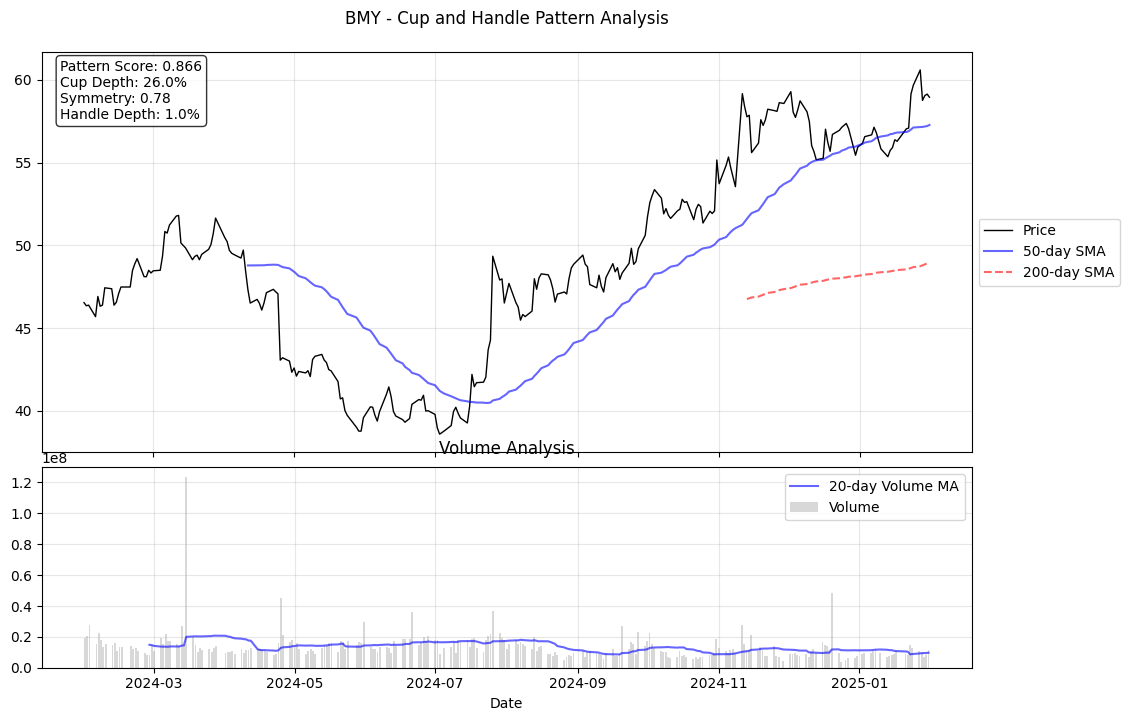

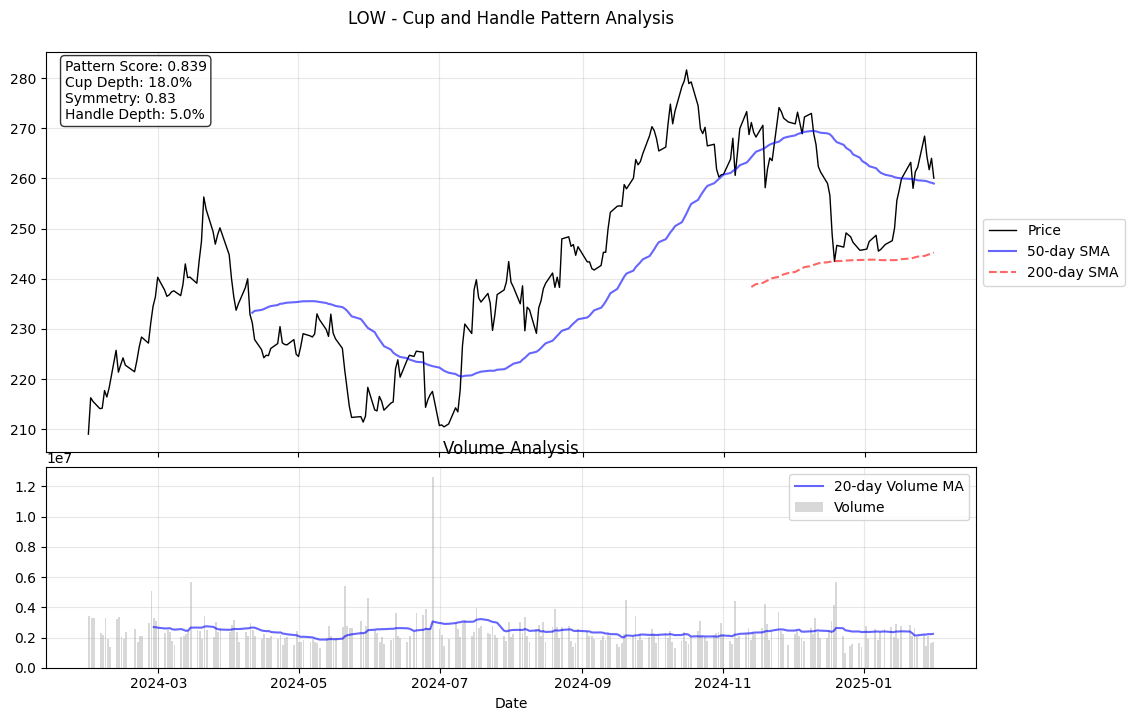

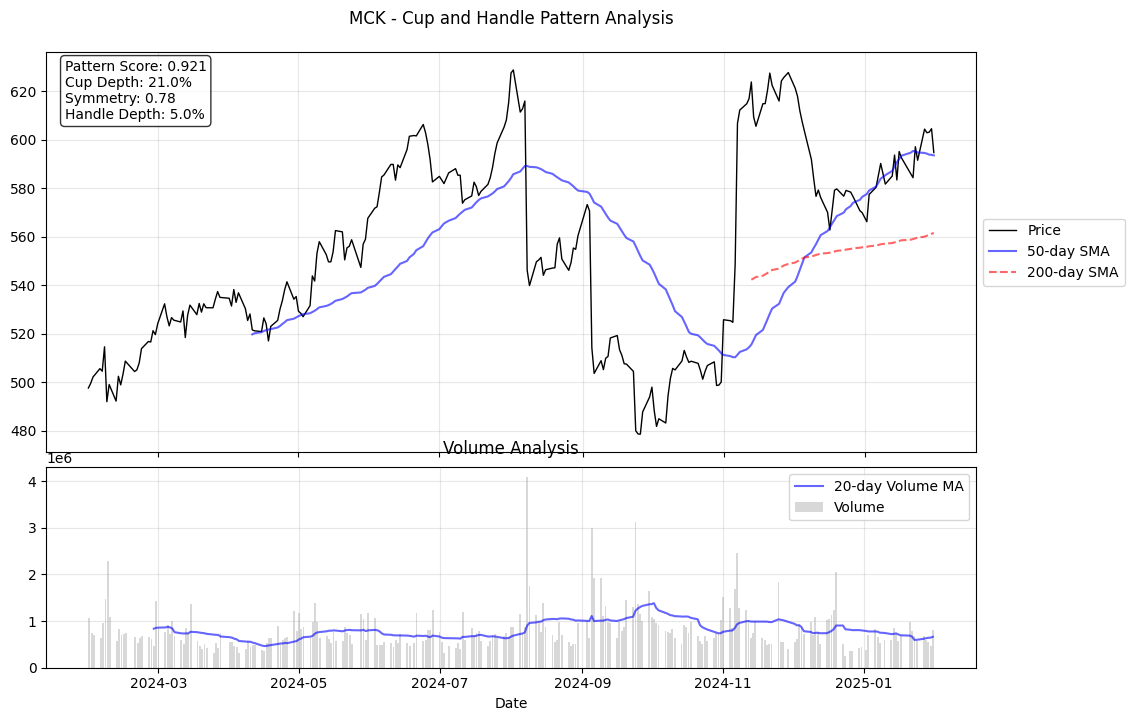

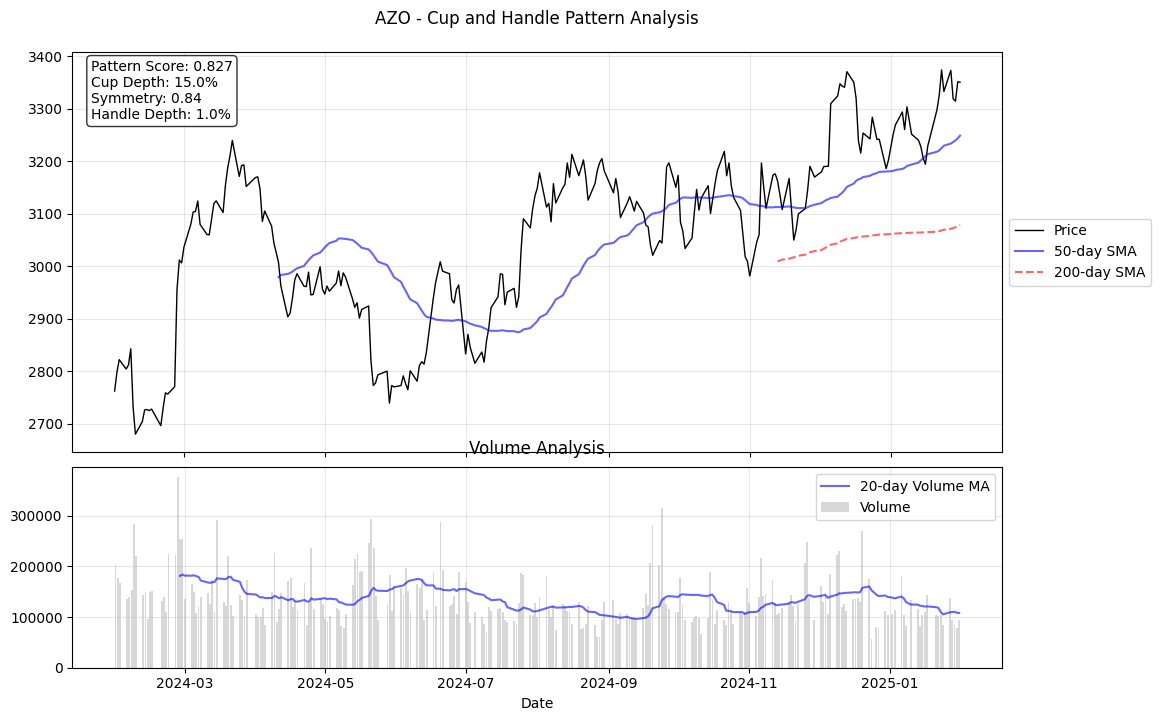

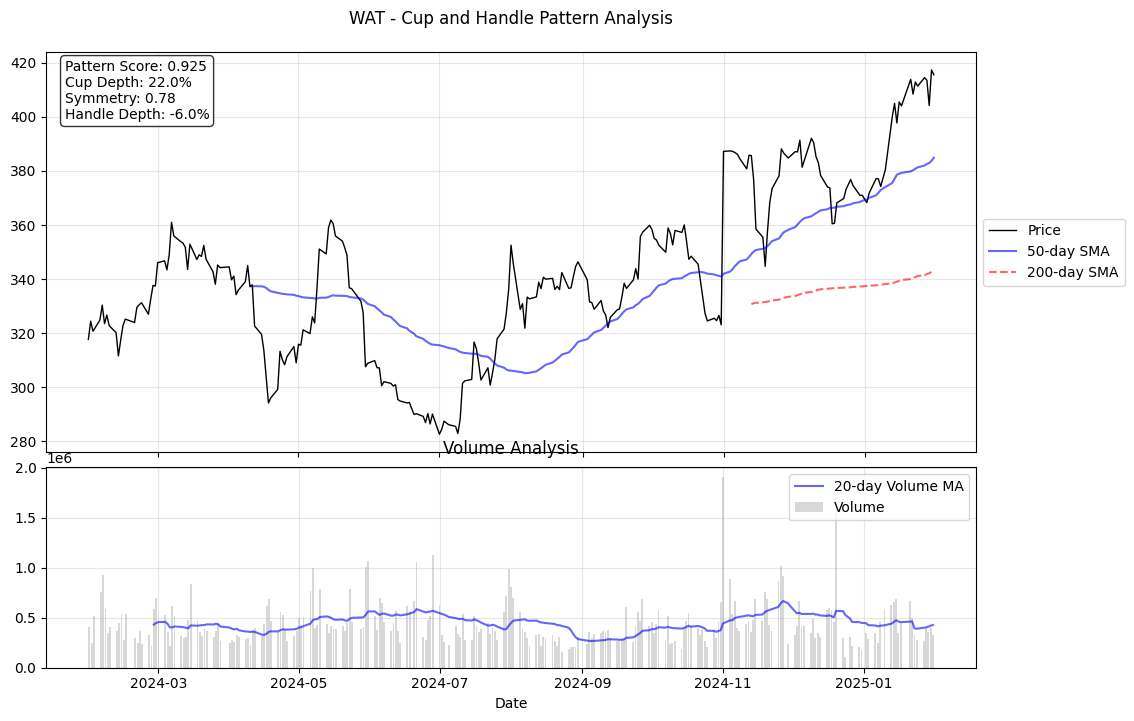

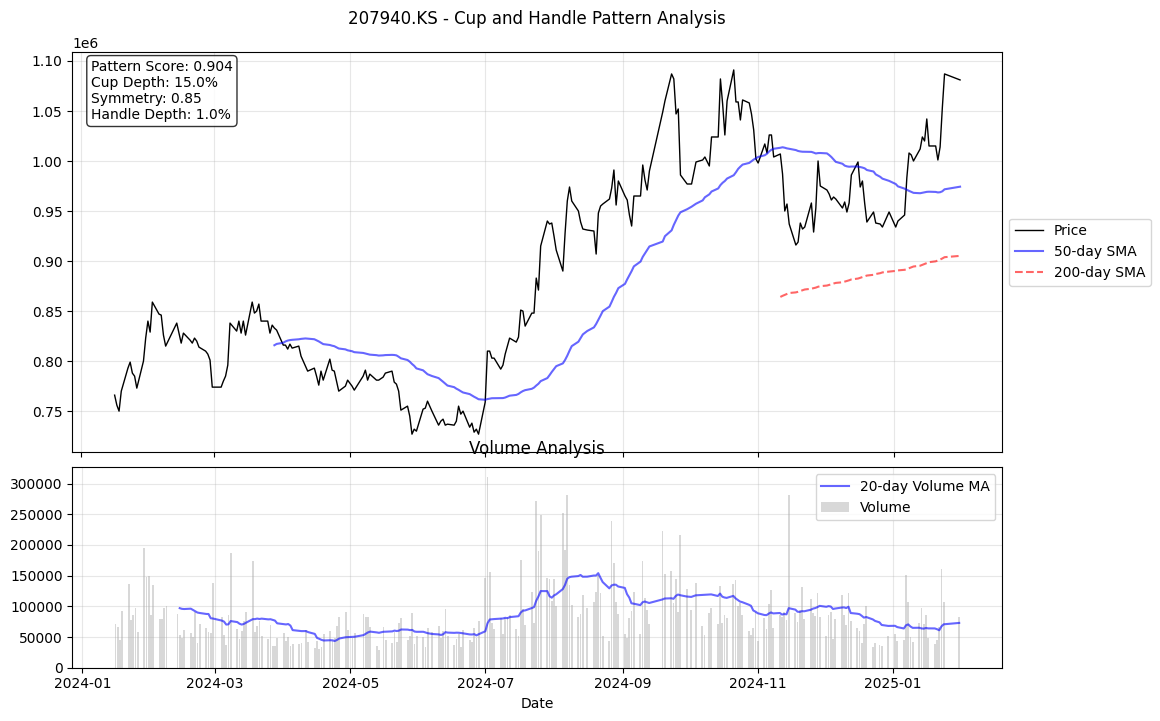

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import matplotlib.patches as patches

class CupHandleDetector:
    def __init__(self, lookback_period=252):
        self.lookback_period = lookback_period

    def identify_pattern_points(self, data):
        prices = data['Close'].values
        n = 20
        local_max_indices = argrelextrema(prices, np.greater, order=n)[0]
        local_min_indices = argrelextrema(prices, np.less, order=n)[0]

        if len(local_max_indices) < 2 or len(local_min_indices) < 1:
            return 0, len(prices)//2, len(prices)-40, len(prices)-1

        cup_start = local_max_indices[0]
        cup_bottom = local_min_indices[len(local_min_indices)//2]
        cup_end = local_max_indices[-2] if len(local_max_indices) > 1 else len(prices)-40
        handle_end = len(prices) - 1

        return cup_start, cup_bottom, cup_end, handle_end

    def calculate_pattern_metrics(self, data):
        try:
            points = self.identify_pattern_points(data)
            cup_start, cup_bottom, cup_end, handle_end = points

            # Validate indices
            if cup_bottom <= cup_start or cup_end <= cup_bottom or handle_end <= cup_end:
                return {'Cup Depth': 0, 'Symmetry': 0, 'Handle Depth': 0, 'Volume Trend': 0}

            cup_depth = ((data['Close'].iloc[cup_start] - data['Close'].iloc[cup_bottom]) /
                        data['Close'].iloc[cup_start])

            # Ensure equal length segments for correlation
            left_cup = data['Close'].iloc[cup_start:cup_bottom].values
            right_cup = data['Close'].iloc[cup_bottom:cup_end].values
            min_len = min(len(left_cup), len(right_cup))

            if min_len < 20:  # Minimum length for valid pattern
                return {'Cup Depth': 0, 'Symmetry': 0, 'Handle Depth': 0, 'Volume Trend': 0}

            left_cup = left_cup[-min_len:]
            right_cup = right_cup[:min_len][::-1]

            if len(left_cup) == len(right_cup) and len(left_cup) > 0:
                symmetry = np.corrcoef(left_cup, right_cup)[0,1]
            else:
                symmetry = 0

            handle_depth = ((data['Close'].iloc[cup_end] - data['Close'].iloc[handle_end]) /
                           data['Close'].iloc[cup_end])

            volume_trend = np.polyfit(np.arange(len(data['Volume'])),
                                    data['Volume'].values, 1)[0]

            return {
                'Cup Depth': cup_depth,
                'Symmetry': symmetry if not np.isnan(symmetry) else 0,
                'Handle Depth': handle_depth,
                'Volume Trend': volume_trend
            }
        except Exception as e:
            print(f"Error in calculate_pattern_metrics: {str(e)}")
            return {
                'Cup Depth': 0,
                'Symmetry': 0,
                'Handle Depth': 0,
                'Volume Trend': 0
            }

    def calculate_pattern_score(self, window):
        if len(window) < self.lookback_period:
            return 0.0

        try:
            metrics = self.calculate_pattern_metrics(window)

            depth_score = 1.0 - abs(0.25 - metrics['Cup Depth']) * 2
            symmetry_score = max(0, metrics['Symmetry'])
            handle_score = 1.0 if metrics['Handle Depth'] <= metrics['Cup Depth']/3 else 0.5
            volume_score = 1.0 if metrics['Volume Trend'] > 0 else 0.5

            price_trend = np.polyfit(np.arange(len(window['Close'])),
                                   window['Close'].values, 1)[0]
            trend_score = 1.0 if price_trend > 0 else 0.0

            final_score = (0.3 * depth_score +
                         0.25 * symmetry_score +
                         0.2 * handle_score +
                         0.15 * volume_score +
                         0.1 * trend_score)

            return float(final_score)

        except Exception as e:
            print(f"Error in pattern score calculation: {str(e)}")
            return 0.0

    def scan_stocks(self, tickers):
        results = []

        for ticker in tickers:
            try:
                stock = yf.Ticker(ticker)
                hist = stock.history(period='2y')

                if len(hist) < self.lookback_period:
                    continue

                recent_window = hist.iloc[-self.lookback_period:]
                pattern_score = self.calculate_pattern_score(recent_window)
                metrics = self.calculate_pattern_metrics(recent_window)

                hist['SMA_50'] = hist['Close'].rolling(window=50).mean()
                hist['SMA_200'] = hist['Close'].rolling(window=200).mean()

                market_cap = stock.info.get('marketCap', 0)
                if '.KS' in ticker:
                    market_cap = market_cap / 100000000  # Convert to 억원
                else:
                    market_cap = market_cap / 1000000000  # Convert to Billion USD

                # Enhanced screening conditions
                if (pattern_score >= 0.75 and
                    0.15 <= metrics['Cup Depth'] <= 0.30 and  # Ideal cup depth
                    metrics['Symmetry'] >= 0.7 and           # Good symmetry
                    metrics['Handle Depth'] <= metrics['Cup Depth']/3):  # Handle depth constraint

                    results.append({
                        'Ticker': ticker,
                        'Pattern_Score': round(pattern_score, 3),
                        'Cup_Depth': round(metrics['Cup Depth'], 2),
                        'Symmetry': round(metrics['Symmetry'], 2),
                        'Handle_Depth': round(metrics['Handle Depth'], 2),
                        'Market_Cap': round(market_cap, 2),
                        'Market_Cap_Unit': '억원' if '.KS' in ticker else 'B$',
                        'Last_Close': round(hist['Close'].iloc[-1], 2),
                        'SMA50_Ratio': round(hist['Close'].iloc[-1] / hist['SMA_50'].iloc[-1], 2),
                        'SMA200_Ratio': round(hist['Close'].iloc[-1] / hist['SMA_200'].iloc[-1], 2),
                        'Volume_Ratio': round(hist['Volume'].iloc[-20:].mean() /
                                     hist['Volume'].iloc[-60:-20].mean(), 2),
                        'Price_Change_3M': round((hist['Close'].iloc[-1] /
                                         hist['Close'].iloc[-60] - 1) * 100, 2)
                    })

            except Exception as e:
                print(f"Error processing {ticker}: {str(e)}")
                continue

        if not results:
            return pd.DataFrame(columns=['Ticker', 'Pattern_Score', 'Cup_Depth', 'Symmetry',
                                       'Handle_Depth', 'Market_Cap', 'Market_Cap_Unit',
                                       'Last_Close', 'SMA50_Ratio', 'SMA200_Ratio',
                                       'Volume_Ratio', 'Price_Change_3M'])

        return pd.DataFrame(results)

def visualize_detected_patterns(results_df):
    """
    Detected cup and handle patterns를 시각화하는 함수

    Args:
        results_df (pd.DataFrame): 감지된 패턴들의 정보가 담긴 데이터프레임
    """
    for idx, row in results_df.iterrows():
        try:
            # Get historical data
            stock = yf.Ticker(row['Ticker'])
            hist = stock.history(period='2y')

            if len(hist) < 252:  # Minimum requirement for pattern
                continue

            # Create a copy to avoid SettingWithCopyWarning
            recent_window = hist.iloc[-252:].copy()

            # Calculate moving averages
            recent_window['SMA_50'] = recent_window['Close'].rolling(window=50).mean()
            recent_window['SMA_200'] = recent_window['Close'].rolling(window=200).mean()
            recent_window['Volume_MA20'] = recent_window['Volume'].rolling(window=20).mean()

            # Create detector instance and get pattern points
            detector = CupHandleDetector()
            cup_start, cup_bottom, cup_end, handle_end = detector.identify_pattern_points(recent_window)

            # Create figure with subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1], gridspec_kw={'hspace': 0.05})

            # Plot price data
            ax1.plot(recent_window.index, recent_window['Close'], 'k-', label='Price', linewidth=1)
            ax1.plot(recent_window.index, recent_window['SMA_50'], 'b-', label='50-day SMA', alpha=0.6)
            ax1.plot(recent_window.index, recent_window['SMA_200'], 'r--', label='200-day SMA', alpha=0.6)

            # Add metrics text box
            metrics_text = f"Pattern Score: {row['Pattern_Score']:.3f}\n"
            metrics_text += f"Cup Depth: {row['Cup_Depth']:.1%}\n"
            metrics_text += f"Symmetry: {row['Symmetry']:.2f}\n"
            metrics_text += f"Handle Depth: {row['Handle_Depth']:.1%}"

            ax1.text(0.02, 0.98, metrics_text,
                    transform=ax1.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Configure price plot
            market = "KRX" if '.KS' in row['Ticker'] else "US"
            ax1.set_title(f"{row['Ticker']} - Cup and Handle Pattern Analysis", pad=20)
            ax1.grid(True, alpha=0.3)
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.set_xticklabels([])  # Remove x-axis labels from top plot

            # Plot volume
            ax2.bar(recent_window.index, recent_window['Volume'], color='gray', alpha=0.3, label='Volume')
            ax2.plot(recent_window.index, recent_window['Volume_MA20'], 'b-', label='20-day Volume MA', alpha=0.6)

            # Configure volume plot
            ax2.set_title('Volume Analysis', pad=10)
            ax2.grid(True, alpha=0.3)
            ax2.legend(loc='upper right')
            ax2.set_xlabel('Date')

            # Format y-axis to use scientific notation
            ax2.yaxis.set_major_formatter(plt.ScientificNotation(1))

            # Adjust layout
            plt.tight_layout()

            # Show plot
            plt.show()

        except Exception as e:
            print(f"Error visualizing {row['Ticker']}: {str(e)}")
            continue




def get_top50_tickers():
    """미국과 한국의 시가총액 상위 50개 기업 추출"""
    # 미국 상위 기업
    us_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'LLY', 'V', 'AVGO',
                'UNH', 'JPM', 'XOM', 'MA', 'JNJ', 'PG', 'HD', 'ORCL', 'MRK', 'ADBE',
                'COST', 'CRM', 'AMD', 'BAC', 'ABBV', 'KO', 'PEP', 'CSCO', 'TMO', 'ACN',
                'MCD', 'NFLX', 'CMCSA', 'WFC', 'DIS', 'LIN', 'TXN', 'VZ', 'INTC', 'INTU',
                'PM', 'DHR', 'NEE', 'MS', 'RTX', 'BMY', 'WMT', 'UPS', 'COP', 'HON',
                'CVX', 'QCOM', 'T', 'CAT', 'AXP', 'IBM', 'DE', 'GS', 'LOW', 'AMGN',
                'UNP', 'BA', 'SPGI', 'AMAT', 'PFE', 'NOW', 'GE', 'ISRG', 'BLK', 'SYK',
                'ADI', 'MDT', 'UBER', 'TJX', 'MMC', 'SBUX', 'GILD', 'CI', 'CB', 'ETN',
                'DUK', 'PLD', 'SO', 'VRTX', 'REGN', 'AON', 'BSX', 'NOC', 'CL', 'BDX',
                'LRCX', 'PNC', 'TGT', 'SLB', 'MMM', 'APD', 'USB', 'HCA', 'MO', 'AEP',
                'SCHW', 'FCX', 'ITW', 'EMR', 'CCI', 'EW', 'FIS', 'GM', 'MCK', 'KLAC',
                'MPC', 'NSC', 'PSX', 'SNPS', 'F', 'SRE', 'CDNS', 'DVN', 'PSA', 'AIG',
                'ADM', 'APH', 'BK', 'CME', 'CSX', 'KMB', 'MSCI', 'TEL', 'TRV',
                'CHTR', 'CNC', 'D', 'EL', 'EOG', 'HUM', 'ICE', 'MET', 'OXY', 'ORLY',
                'PGR', 'SYY', 'TT', 'VLO', 'WM', 'YUM', 'AFL', 'AZO', 'COF', 'DG',
                'DLR', 'DOW', 'EXC', 'FITB', 'GD', 'GIS', 'GPN', 'HAL', 'HPQ', 'HRL',
                'HSY', 'IQV', 'KDP', 'KMI', 'LHX', 'MAR', 'MSI', 'NEM', 'NUE', 'ROK',
                'STZ', 'SWK', 'TMUS', 'TXT', 'URI', 'WAT', 'AEE', 'ALB', 'ALL', 'AMP',
                'AVB', 'BAX', 'BBY', 'BF-B', 'CARR', 'CDW', 'CF', 'CHD', 'CMG', 'CNP',
                'CTAS', 'DFS', 'DTE', 'ED', 'EFX', 'EIX', 'EMN', 'ES', 'ETR', 'FAST']

    # 한국 상위 기업
    kr_tickers = ['005930.KS', '373220.KS', '000660.KS', '207940.KS', '005935.KS', '005380.KS',
                '000270.KS', '051910.KS', '035420.KS', '068270.KS', '005490.KS', '012330.KS',
                '066570.KS', '028260.KS', '086790.KS', '323410.KS', '003670.KS', '096770.KS',
                '055550.KS', '316140.KS', '017670.KS', '003550.KS', '032830.KS', '015760.KS',
                '034730.KS', '138040.KS', '011200.KS', '009150.KS', '047810.KS', '036570.KS',
                '000810.KS', '352820.KS', '018260.KS', '033780.KS', '010130.KS', '010950.KS',
                '011170.KS', '035720.KS', '105560.KS', '086520.KS', '090430.KS', '024110.KS',
                '011070.KS', '128940.KS', '021240.KS', '326030.KS', '034020.KS', '003490.KS',
                '034220.KS', '097950.KS', '329180.KS', '259960.KS', '042700.KS', '402340.KS',
                '000100.KS', '012450.KS', '003570.KS', '267250.KS', '271560.KS', '030200.KS',
                '361610.KS', '086280.KS', '011780.KS', '251270.KS', '006400.KS', '161390.KS',
                '028050.KS', '009540.KS', '010140.KS', '035250.KS', '004020.KS', '032640.KS',
                '139480.KS', '001570.KS', '010060.KS', '028670.KS', '078930.KS', '016360.KS',
                '008770.KS', '000720.KS', '302440.KS', '011790.KS', '006800.KS', '005830.KS',
                '004990.KS', '241560.KS', '001450.KS', '018880.KS', '004370.KS', '010620.KS',
                '039490.KS', '112610.KS', '071050.KS', '009830.KS', '375500.KS', '006260.KS',
                '000880.KS', '023530.KS', '009240.KS', '001040.KS', '047050.KS', '030000.KS',
                '018670.KS', '004170.KS', '069620.KS', '005070.KS', '280360.KS', '004000.KS',
                '096530.KS', '051600.KS', '383220.KS', '036460.KS', '007070.KS', '014680.KS',
                '009420.KS', '001740.KS', '000120.KS', '002790.KS', '003240.KS', '029780.KS',
                '019170.KS', '005940.KS', '088350.KS', '002380.KS', '011210.KS', '001120.KS',
                '028260.KS', '000990.KS',  '005300.KS', '002710.KS', '079550.KS',
                '012750.KS', '003090.KS', '007310.KS', '002350.KS', '004800.KS', '014820.KS',
                '006260.KS', '020000.KS', '004990.KS', '002030.KS', '161890.KS', '051900.KS',
                '003520.KS', '001440.KS', '008930.KS', '007120.KS', '092230.KS', '009900.KS',
                '001230.KS', '044380.KS', '015590.KS', '000210.KS', '002960.KS', '012450.KS',
                '016380.KS', '336260.KS', '192820.KS', '139480.KS', '004170.KS', '000850.KS',
                '003000.KS', '023590.KS', '138040.KS', '039130.KS', '036570.KS', '005250.KS',
                '034730.KS', '055550.KS', '008770.KS', '010950.KS', '001060.KS', '024110.KS',
                '009150.KS', '086790.KS', '003550.KS', '000080.KS', '042700.KS', '017800.KS',
                '004800.KS', '001450.KS', '010130.KS', '006650.KS', '053800.KS', '001380.KS',
                '005440.KS', '005380.KS', '014820.KS', '009240.KS', '010060.KS', '090430.KS',
                '006360.KS', '005850.KS', '120110.KS', '004170.KS', '093370.KS', '001040.KS']

    return us_tickers + kr_tickers

if __name__ == "__main__":
    detector = CupHandleDetector()
    top50_tickers = get_top50_tickers()
    results_df = detector.scan_stocks(top50_tickers)

    if not results_df.empty:
        us_results = results_df[~results_df['Ticker'].str.contains('.KS')]
        kr_results = results_df[results_df['Ticker'].str.contains('.KS')]

        print("\nUS Market Cup and Handle Patterns:")
        if not us_results.empty:
            print(us_results.to_string())
            visualize_detected_patterns(us_results)  # Visualize US patterns
        else:
            print("No patterns detected in US market")

        print("\nKorean Market Cup and Handle Patterns:")
        if not kr_results.empty:
            print(kr_results.to_string())
            visualize_detected_patterns(kr_results)  # Visualize Korean patterns
        else:
            print("No patterns detected in Korean market")
    else:
        print("No patterns detected in either market")



#CUP AND HANDLE 패턴의 이상적 수치:

#Cup Depth: 15-30% (0.15-0.30) 너무 깊으면(>35%) 실패 확률 증가  너무 얕으면(<10%) 상승 동력 부족

#Symmetry: 0.8 이상이 이상적: 0.9 이상: 매우 강한 대칭성, 0.7-0.8: 허용 가능한 범위, 0.7 미만: 패턴 신뢰도 떨어짐

#Handle Depth: Cup Depth의 1/3 이하, 이상적으로는 Cup Depth의 15-25%, 절대값으로는 5-15% 범위가 최적


#Pattern_Score (0.7~1.0): 0.85 이상: 매우 강한 패턴, 0.75~0.85: 중간 강도 패턴, 0.7~0.75: 약한 패턴

#SMA50_Ratio와 SMA200_Ratio: 1 이상: 상승 추세, 1 미만: 하락 추세 두 지표 모두 1 이상이면 더욱 강력한 매수 신호
#Volume_Ratio:1.5 이상: 거래량 급증, 0.7 미만: 거래량 급감, 이상적으로는 1.2 이상을 유지해야 함
#Price_Change_3M: 패턴의 형성 과정에서 10% 이상의 상승이 바람직, 음수면 패턴의 신뢰도가 떨어짐